# Part 2: Replay
I now explore how stimulus-specific replay could emerge in this network model via history-dependent excitability, that is, the tendency of a node to exhibit a temporarily increased activation probability following its own recent activation in the past. History-dependent excitability of a node could arise from a number of molecular mechanisms in its constituent neurons, such as slow ion channel dynamics or calcium dynamics (various other mechanisms are discussed and referenced in [Baroni et al., 2010][1]). Alternatively, it could arise via low levels of persistent electrical activity whose onset is triggered by the activation of the original node, and which sends excitatory feedback to that node. Such a hypothesis is consistent with evidence for low levels of stimulus-tuned activity in early sensory cortex that persists during the delay period of a working memory task ([Harrison and Tong, 2009][2], [Super et al., 2001][3], [Lee et al., 2013][4], [Han et al., 2013][5]).

Here I abstract away from a specific mechanism of history dependent excitability and instead model it as an additional effective input $s_{hde}$ that a node receives at all times subsequent to its original activation.

Summarially, at this point in my network model, a node may receive three types of inputs:
* input from upstream nodes, weighted by their connectivity
* external drive
* effective input via history-dependent excitability

[1]: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0015023
[2]: http://www.nature.com/nature/journal/v458/n7238/full/nature07832.html
[3]: http://www.ncbi.nlm.nih.gov/pubmed/11441187
[4]: http://www.nature.com/neuro/journal/v16/n8/full/nn.3452.html
[5]: http://www.ncbi.nlm.nih.gov/pubmed/23380167

In [1]:
%matplotlib inline
import softmax_chains_replay

### Stimulus-specific replay
Here I demonstrate that activating a specific chain in the network causes segments of that chain to replay even after the offset of the stimulus. For the first half of each trial I present sequential external drives activating a specific chain. On the second half of the trial I present no inputs, so all activity is spontaneous. The dashed line in the figure indicates the offset of external drive.

In [2]:
CONFIG = {
    'SEED': None,
    
    'N_CHAINS': 9,  # HOW MANY CHAINS
    'CHAIN_LENGTH': 4,  # NUMBER OF NODES IN A CHAIN
    
    'W_STRONG': 2,  # CONNECTION STRENGTH BETWEEN SUCCESSIVE NODES IN A CHAIN
    
    'GAIN': 7,  # GAIN TERM IN WINNER-TAKE-ALL MECHANISM
    'HDE_INPUT_VALUE': 1,  # VALUE OF HISTORY-DEPENDENT INPUT TO A NODE, GIVEN THAT NODE'S RECENT ACTIVATION
    
    # WHICH NODES TO PROVIDE EXTERNAL DRIVE TO WHEN
    'DRIVE_BY_COORDINATE': [
            [((chain_idx, chain_pos), 3) for chain_pos in range(4)]  # DRIVE CHAINS DIRECTLY IN FIRST HALF OF TRIAL
            + 4 * [((0, 0), 0)]  # PROVIDE ZERO INPUT IN SECOND HALF OF TRIAL
            for chain_idx in range(6)  # DRIVE A DIFFERENT CHAIN EACH TRIAL
        ],
    
    'N_TRIALS': 6,
    
    'FIG_SIZE': (15, 8),
    'COLORS': [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1), (.5, .5, 0), (.5, .5, .5), (.5, 0, 0)],
    'LW': 2,
    'FONT_SIZE': 16,
}

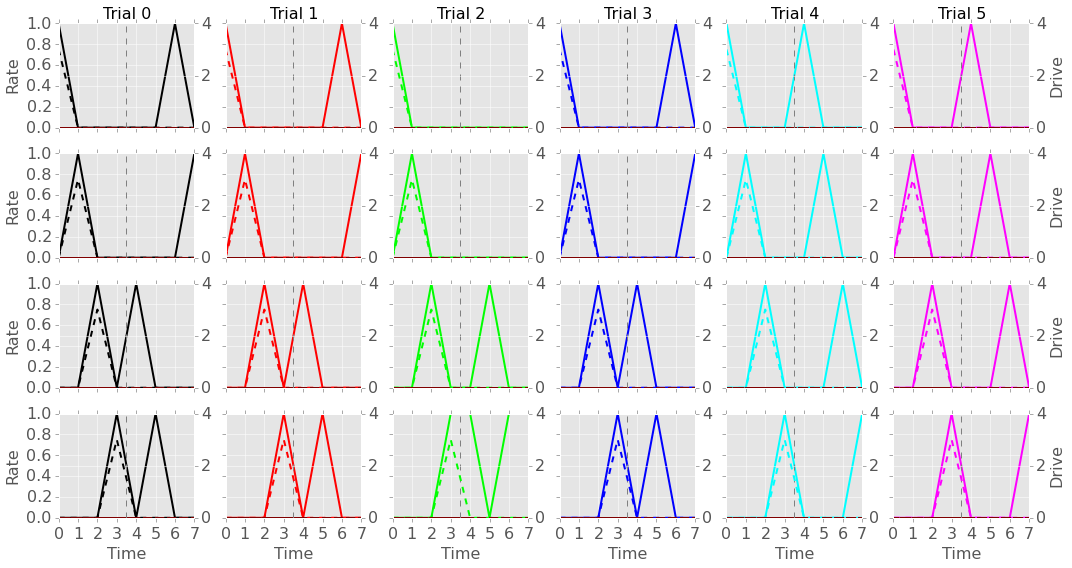

In [3]:
softmax_chains_replay.replay(CONFIG)

#### Figure description
The vertical dashed gray line indicates the offset of external drive and onset of spontaneous activity. As expected, since activating individual nodes leaves them in a "primed" state, nodes in an activated chain are more likely to activate spontaneously. When they do, the subsequently active nodes are those that follow in the chain.

### Replay depends on history-dependent excitability
If we set the $s_{hde} = 0$, we see that stimulus-specific replay no longer occurs.

In [4]:
CONFIG['HDE_INPUT_VALUE'] = 0

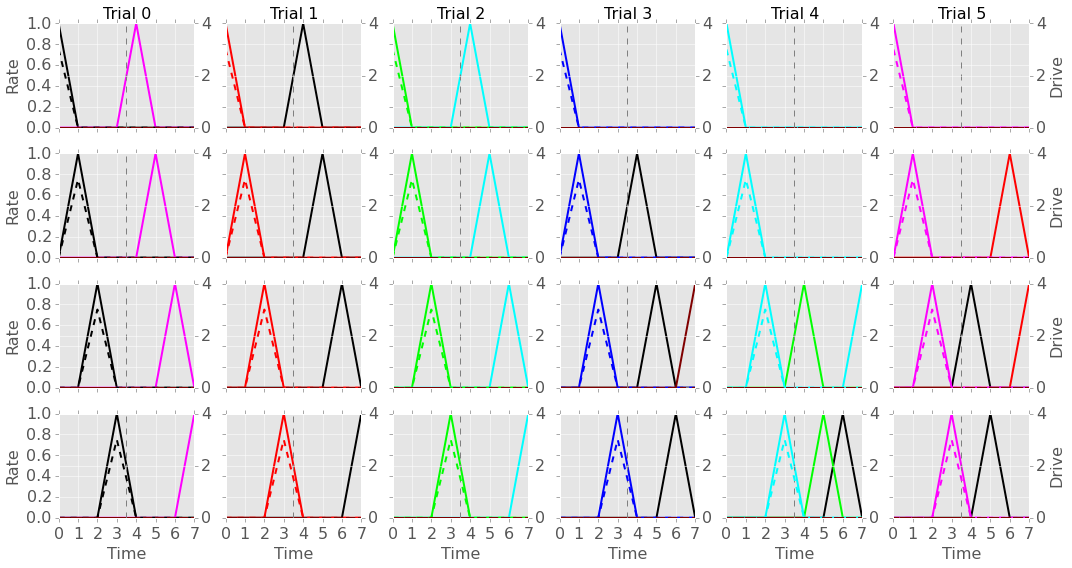

In [5]:
softmax_chains_replay.replay(CONFIG)

#### Figure description
This is because after the external drive is finished and a chain finishes there is no preference for any node to activate after any other.

### External drive that is similar but not identical to prior activity patterns
Returning to the case of a nonzero history-dependent excitability $s_{hde}$: If the external drive activates most of one chain and a small portion of another, the subsequent spontaneously active sequences will show a preference for the more activated chain. This corresponds to a sort of after-the-fact pattern completion.

In [18]:
CONFIG['HDE_INPUT_VALUE'] = 1
CONFIG['DRIVE_BY_COORDINATE'] = [
    # DRIVE SEQUENCE (BLACK-0, BLACK-1, RED-2, BLACK-3) IN FIRST HALF OF TRIAL
    [((0, chain_pos), 3) if chain_pos != 2 else ((1, chain_pos), 3) for chain_pos in range(4)]
    + 4 * [((0, 0), 0)]  # PROVIDE ZERO DRIVE FOR SECOND HALF OF TRIAL
    for _ in range(6)  # DRIVE THE SAME CHAIN IN EACH TRIAL
]

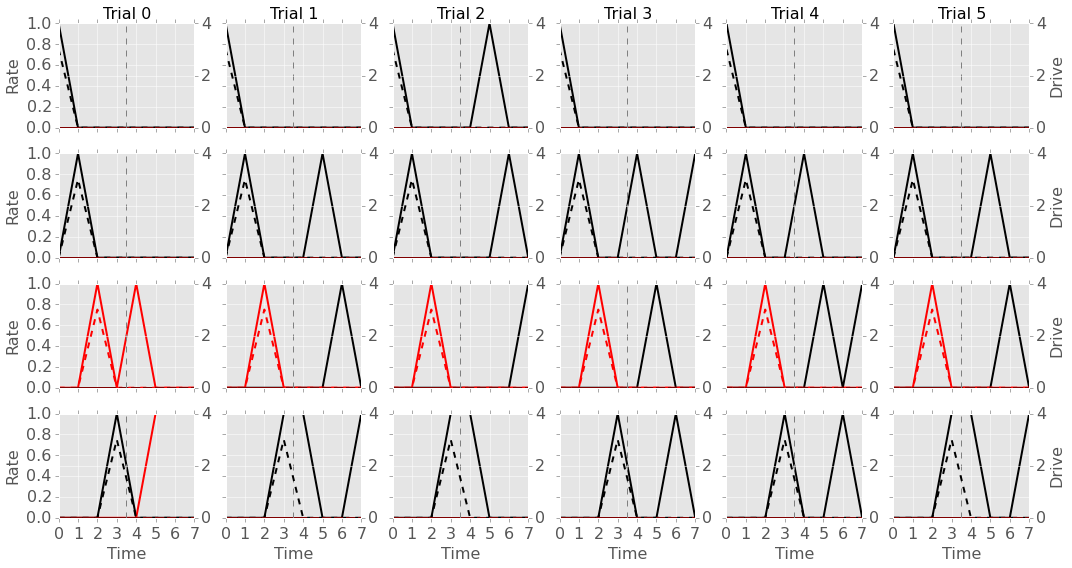

In [7]:
softmax_chains_replay.replay(CONFIG)

#### Figure description
Here I have presented the external drive sequence (black-0, black-1, red-2, black-3). Because of this, we see that after the drive is turned off, it is mostly the black chain that activates spontaneously. Interestingly when this occurs, (black-2) activates after (black-1), even though (black-2) was not activated originally by the external drive. We can interpret this as a sort of pattern completion: after the drive is turned off, the pattern that will most probably activate is the *intrinsic* pattern most similar to the external drive sequence, namely some subsequence of (black-0, black-1, black-2, black-3). Occasionally we also see the second half of the red chain activate spontaneously. However, we never see the exact sequence (black-0, black-1, red-2, black-3) we presented activate spontaneously.

Below, however, we see that when the evoked sequence equally resembles two prior sequences, the subsequently recruited spontaneous sequence has an equal probability of starting from either of the two prior sequences.

In [8]:
CONFIG['DRIVE_BY_COORDINATE'] = [
    # PROVIDE A DRIVE TO THE FIRST HALF OF THE BLACK CHAIN AND THE SECOND HALF OF THE RED CHAIN
    [((0, chain_pos), 3) if chain_pos < 2 else ((1, chain_pos), 3) for chain_pos in range(4)]
    + 4 * [((0, 0), 0)]  # PROVIDE ZERO INPUT IN THE SECOND HALF OF THE TRIAL
    for _ in range(6)  # PROVIDE THE SAME DRIVE IN EACH TRIAL
]

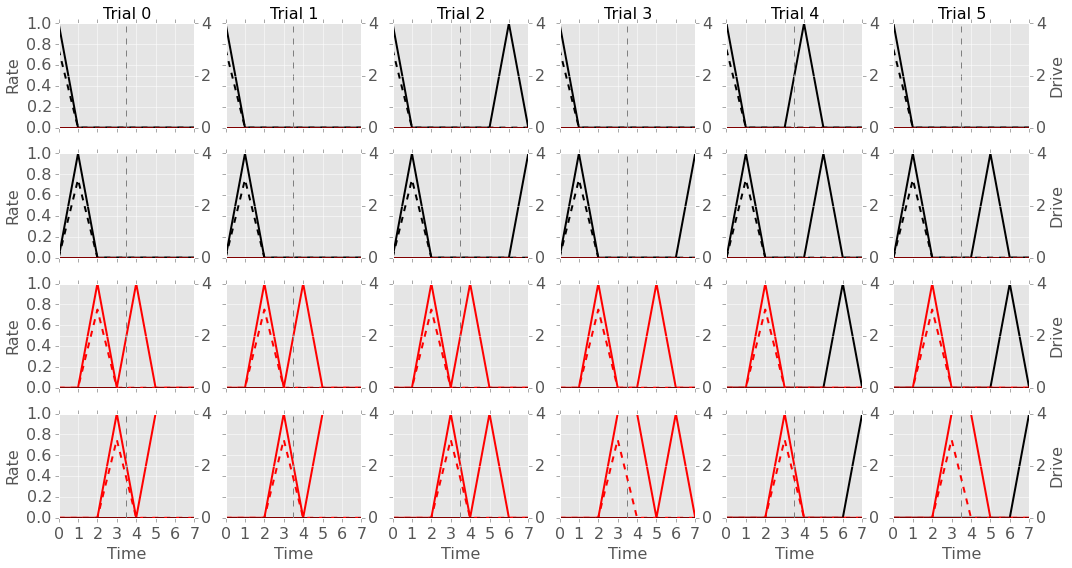

In [9]:
softmax_chains_replay.replay(CONFIG)

#### Figure description
Here the sequence (black-0, black-1, red-2, red-3) was induced by external drive. When the drive is turned off, there is an equal probability that the black and red chains will be activated. 

### Replay of prior patterns elicited by weak drive
When the drive is weak and the evoked activity pattern does not perfectly follow the drive, the replayed activity will reflect not the drive explicitly, but only the activity pattern it elicited.

In [10]:
CONFIG['DRIVE_BY_COORDINATE'] = [
    # PROVIDE WEAK DRIVE THAT GETS OVERRIDDEN BY PRIOR PATTERNS
    [((chain_idx, chain_pos), 1) if chain_pos != 2 else (((chain_idx + 1)%6, chain_pos), 1) for chain_pos in range(4)]
    + 4 * [((0, 0), 0)]
    for chain_idx in range(6)
]

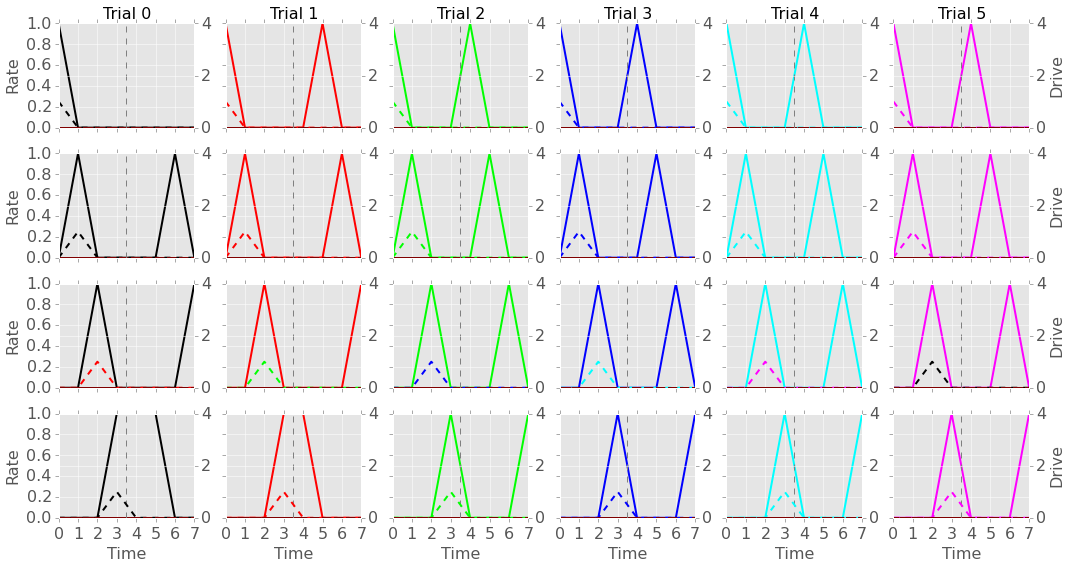

In [11]:
softmax_chains_replay.replay(CONFIG)

#### Figure description
Here we try to elicit the pattern (x-0, x-1, y-2, x-3), but since the drive is weak, the activity pattern does not completely match the drive that elicited it and ends up being (x-0, x-1, x-2, x-3). The replayed activity pattern thus follows the original activity pattern, not the original drive.

# Weak connections and their role in the replay of novel sequences
I now consider how a network with additional connections weakly linking the chains can allow the network to remember and replay a certain subset of *novel* sequences. For the sake of argument (again choosing the simplest model to illustrate the point) consider a network augmented as in the diagram below.

<img src="files/softmax_chains_weak_links.png" width="500">

Here, node 1 of each chain connects weakly to the node 2 of the chain immediately below it. This generalizes the previous network to the more biological situation of the attractors in a network not being completely isolated from one another. Whereas strong connections have weight $w_{strong}$, weak connections have weight $w_{weak} < w_{strong}$.

### Weak connections do not need to affect prior sequence distribution
Here we show that a connection can be weak enough that it does not interfere with the spontaneous activation of intrinsic patterns. That is, if you were to estimate the intrinsic activity distribution via sampling, it would be effectively identical to that drawn from the network without the weak connections.

In [12]:
CONFIG['W_WEAK'] = 1  # THE STRENGTH OF THE CONNECTIONS BETWEEN CHAINS
CONFIG['WEAK_CXN_IDXS'] = (2, 1)  # WHICH NODES SHOULD BE USED TO CONNECT CHAINS
CONFIG['DRIVE_BY_COORDINATE'] = [
    # PROVIDE DRIVE TO FIRST NODE IN A CHAIN ON FIRST TIME STEP AND NOTHING ELSE
    [((chain_idx, 0), 1)] + 3 * [((0, 0), 0)]
    for chain_idx in range(6)  # ACTIVATE A DIFFERENT CHAIN EACH TRIAL
]

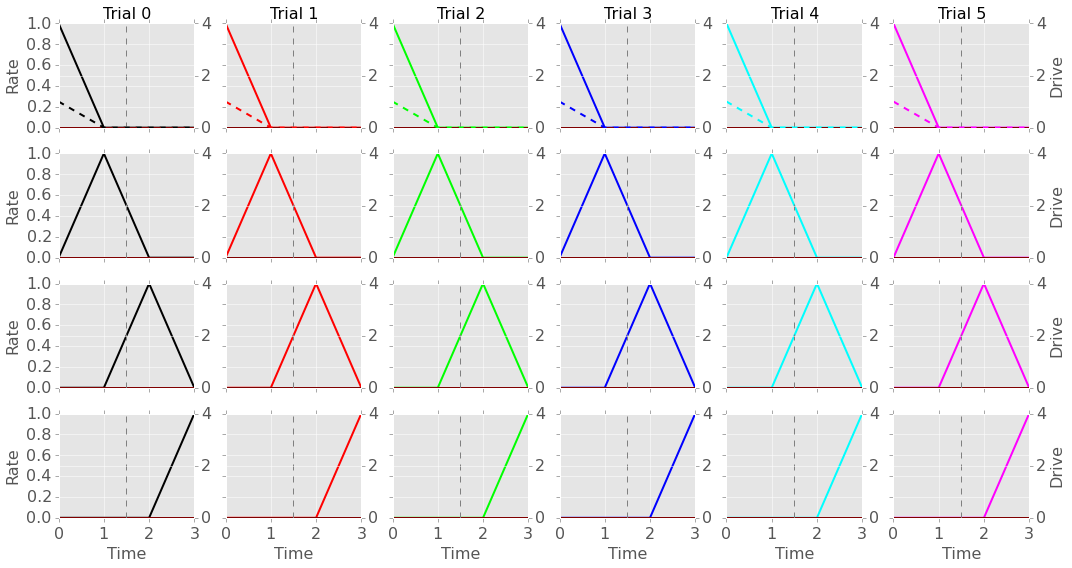

In [13]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

#### Figure description
Here we see that even though weak connections are present, when the first node in each primary chain is stimulated the rest of the primary chain is activated.

### Weak connections can, however, affect replay
The weak connections are strong enough, however, that novel patterns involving the two sequences it links can emerge in subsequent spontaneous activity with a significant probability. Specifically, because the network contains weak links between chains, history-dependent excitability allows novel sequences to replayed if they comprise ordered segments of the primary chains. For example, below I drive the network with sequence (black-0, black-1, red-2, red-3). Even though this sequence would never arise spontaneously, after it has been elicited once by external drive, the next time (black-1) is activated, (black-1)'s weak input to (red-2) combined with (red-2)'s increased excitability brings (red-2)'s total effective input up to a value such that it can compete with (black-2)'s.

In [14]:
CONFIG['DRIVE_BY_COORDINATE'] = [
    # ACTIVATE FIRST HALF OF BLACK CHAIN AND SECOND HALF OF RED CHAIN
    [((0, chain_pos), 3) if chain_pos < 2 else ((1, chain_pos), 3) for chain_pos in range(4)] + 
    [((0, 0), 0), ((0, 0), 0), ((0, 0), 0), ((0, 0), 0)]
    for _ in range(6)
]

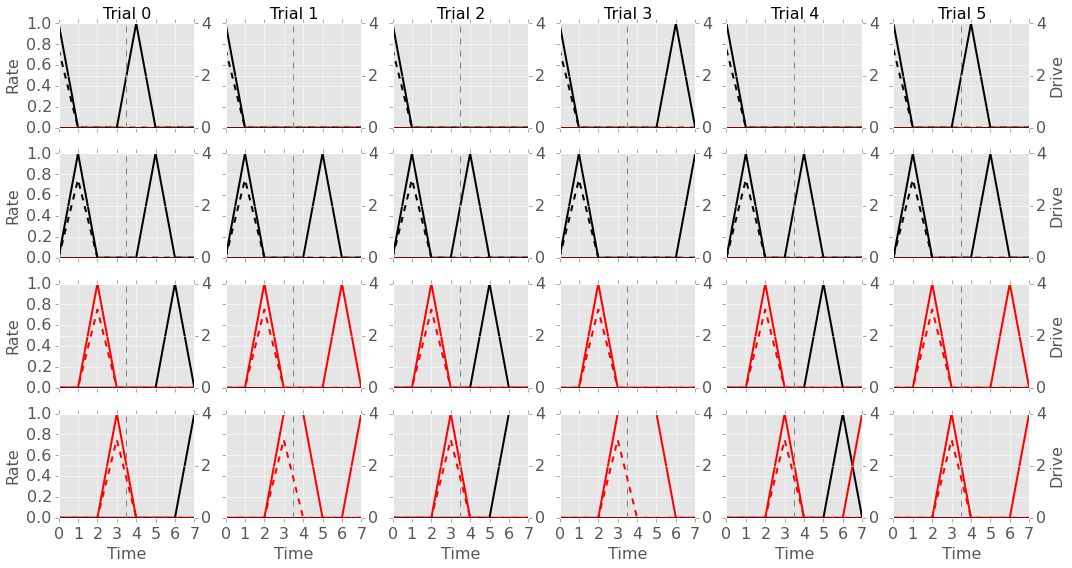

In [15]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

#### Figure description
Here we see that even though the (black-1, red-2) sequence never arose spontaneously prior to the external drive (black-0, black-1, red-2, red-3), the weak connections allow it to spontaneously arise via history-depenendent excitability after it has already occurred in the recent past. Importantly, no synaptic modifications are required for this to occur.

If we increase the history-dependent input value, we expect the repetition of the novel (black-1, red-2) transition to be more probable.

In [16]:
CONFIG['HDE_INPUT_VALUE'] = 2

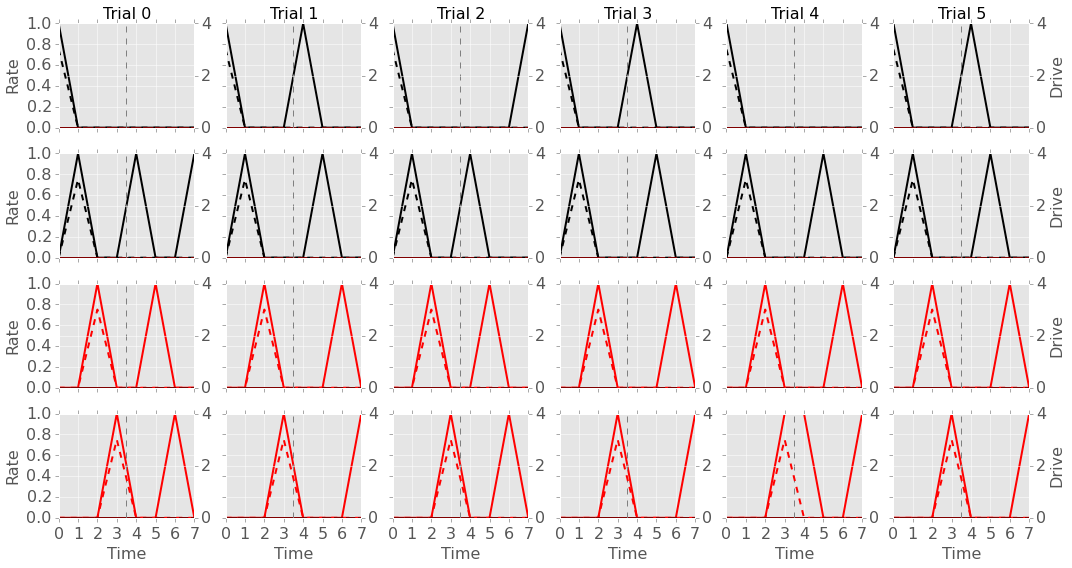

In [17]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

#### Figure description
And in fact this is what we see.

### Summary of part 2
In part 2, I've used a simple network model to show how history-dependent excitability, that is, the tendency of a recently activated node to persist in a state in which it effectively receives additional sustained input, can lead to stimulus-dependent replay of activation sequences. Importantly, the sequences that get replayed with higher probability are the prior patterns most similar to the sequence elicited by the external drive.

History-dependent excitability also allows the network to replay novel sequences if the network contains weak connections betweeen its intrinsically probable sequences. This is because when a node is receiving effective input via history-dependent excitability, the effect of the weak input suddenly becomes important (since it is multiplied with the history-dependent input via the exponential). Thus, the novel sequence can compete with the intrinsic sequence.

In short, this demonstrates the utility of short-term excitability changes for replay, which could be a useful tool in one-shot learning.

### [Go to part 3 (separation of spatial and temporal information, and one-shot learning)](softmax_chains_planning_and_learning.ipynb)